# Models

Build models to see how much each feature contributes to productivity

- Models
    - LinearRegression
    - ExplainableBoostingRegressor
- Features
    - Education
    - Population
    - R&D Expenditure
    
## Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
# See: ../src/data/make_dataset.py
df = pd.read_csv('../data/interim/dataset.csv')
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,hrst,tax_rate
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,53.5,42.72
1,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,53.5,46.06
2,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,53.5,49.53
3,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,53.5,18.94
4,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,53.5,27.59


## Add Trends

There are several ways to capture trends.

- Move data to n years (`shift`)
- Take the mean of n years
- ...

In [3]:
features = ['education', 'population', 'rd_expenditure', 'fertility_rate', 'hrst', 'tax_rate']
shift_range = [1, 2]

def add_trends(df):
    for feature in features:
        for shift in shift_range:
            df[f'{feature}_shift_{shift}'] = df.sort_values('year').groupby(['GEO'])[feature].shift(shift)
            df[f'{feature}_diff_{shift}'] = df[feature] - df[f'{feature}_shift_{shift}']

add_trends(df)
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,...,fertility_rate_shift_2,fertility_rate_diff_2,hrst_shift_1,hrst_diff_1,hrst_shift_2,hrst_diff_2,tax_rate_shift_1,tax_rate_diff_1,tax_rate_shift_2,tax_rate_diff_2
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.86219,0.0,49.3,4.2,49.3,4.2,27.54,18.52,33.93,12.13
2,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.86219,0.0,45.7,7.8,45.7,7.8,27.54,21.99,33.93,15.60
3,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.86219,0.0,53.5,0.0,45.7,7.8,49.53,-30.59,27.54,-8.60
4,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.86219,0.0,53.5,0.0,53.5,0.0,18.94,8.65,49.53,-21.94


## Add Aggregation Features

In [4]:
agg_params = {}
for feature in features:
    for shift in shift_range:
        agg_params[f'{feature}_shift_{shift}_mean'] = (f'{feature}_shift_{shift}', 'mean')

agg = df.groupby('year').agg(**agg_params).reset_index()
df = df.merge(agg, on='year')
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,...,population_shift_1_mean,population_shift_2_mean,rd_expenditure_shift_1_mean,rd_expenditure_shift_2_mean,fertility_rate_shift_1_mean,fertility_rate_shift_2_mean,hrst_shift_1_mean,hrst_shift_2_mean,tax_rate_shift_1_mean,tax_rate_shift_2_mean
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.694488e+07,1.694488e+07,1.518333,1.518333,1.631634,1.631634,41.355175,41.361351,22.654184,22.651739
1,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.694488e+07,1.694488e+07,1.518333,1.518333,1.631634,1.631634,41.355175,41.361351,22.654184,22.651739
2,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.694488e+07,1.694488e+07,1.518333,1.518333,1.631634,1.631634,41.355175,41.361351,22.654184,22.651739
3,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.694488e+07,1.694488e+07,1.518333,1.518333,1.631634,1.631634,41.355175,41.361351,22.654184,22.651739
4,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,1.694488e+07,1.694488e+07,1.518333,1.518333,1.631634,1.631634,41.355175,41.361351,22.654184,22.651739


In [5]:
for feature in features:
    for shift in shift_range:
        df[f'{feature}_shift_{shift}_mean_diff'] = df[f'{feature}_shift_{shift}'] - df[f'{feature}_shift_{shift}_mean']
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,...,population_shift_1_mean_diff,population_shift_2_mean_diff,rd_expenditure_shift_1_mean_diff,rd_expenditure_shift_2_mean_diff,fertility_rate_shift_1_mean_diff,fertility_rate_shift_2_mean_diff,hrst_shift_1_mean_diff,hrst_shift_2_mean_diff,tax_rate_shift_1_mean_diff,tax_rate_shift_2_mean_diff
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,7.944825,7.938649,4.885816,11.278261
2,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,4.344825,4.338649,4.885816,11.278261
3,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,12.144825,4.338649,26.875816,4.888261
4,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,12.144825,12.138649,-3.714184,26.878261


## Scale Features

In [6]:
shift_1_features = [
    'education_shift_1',
    'population_shift_1',
    'rd_expenditure_shift_1',
    'fertility_rate_shift_1',
    'hrst_shift_1',
    'tax_rate_shift_1',
]

shift_2_features = [
    'education_shift_2',
    'population_shift_2',
    'rd_expenditure_shift_2',
    'fertility_rate_shift_2',
    'hrst_shift_2',
    'tax_rate_shift_1',
]

all_features = shift_1_features + shift_2_features

def scale(df):
    for column in all_features:
        scaler = MinMaxScaler()
        df[column] = scaler.fit_transform(df[[column]])

scale(df)
df.head()

,year,GEO,UNIT,NA_ITEM,compensation,Flag and Footnotes,education,population,rd_expenditure,fertility_rate,...,population_shift_1_mean_diff,population_shift_2_mean_diff,rd_expenditure_shift_1_mean_diff,rd_expenditure_shift_2_mean_diff,fertility_rate_shift_1_mean_diff,fertility_rate_shift_2_mean_diff,hrst_shift_1_mean_diff,hrst_shift_2_mean_diff,tax_rate_shift_1_mean_diff,tax_rate_shift_2_mean_diff
0,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,7.944825,7.938649,4.885816,11.278261
2,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,4.344825,4.338649,4.885816,11.278261
3,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,12.144825,4.338649,26.875816,4.888261
4,2010,Belgium,Euro,Compensation of employees per hour worked,34.3,NaN,48.457143,10839905,2.06,1.86219,...,-6.104977e+06,-6.104977e+06,0.541667,0.541667,0.230556,0.230556,12.144825,12.138649,-3.714184,26.878261


## Split Dataset

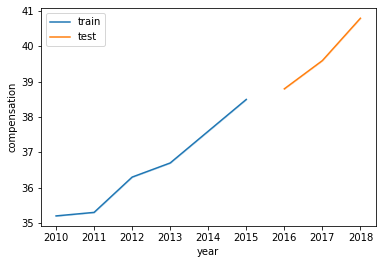

train shape: (7020, 60), test shape: (3510, 60)


In [7]:
train_size = 0.7

years = df['year'].unique()
years = sorted(years)
pivot = int(len(years) * train_size)
train_index = years[:pivot]
test_index = years[pivot:]

train_df = df[df['year'].isin(train_index)]
test_df = df[df['year'].isin(test_index)]

train_temp = train_df[train_df['GEO'] == 'Denmark']
test_temp = test_df[test_df['GEO'] == 'Denmark']
sns.lineplot(data=train_temp, x='year', y='compensation', label='train')
sns.lineplot(data=test_temp, x='year', y='compensation', label='test')
plt.show()

print(f'train shape: {train_df.shape}, test shape: {test_df.shape}')

In [8]:
# train_df = pd.read_csv('../data/interim/train.csv')
# test_df = pd.read_csv('../data/interim/test.csv')
# train_df.head()

## Visualization for Train Dataset

- Correlation
- jointplot
- pairplot

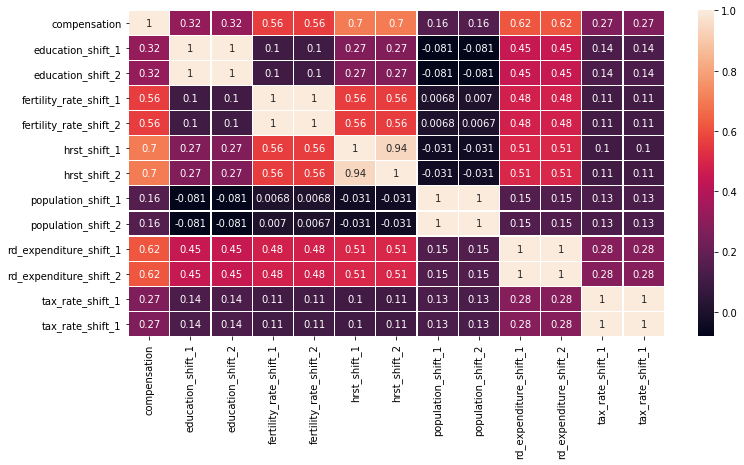

In [9]:
features = [
    sorted(all_features),
]

for fs in features:
    corr = train_df[
        ['compensation'] + fs
    ].corr()
    plt.figure(figsize=(12,6))
    sns.heatmap(corr, annot=True, linewidths=0.2)
    plt.show()

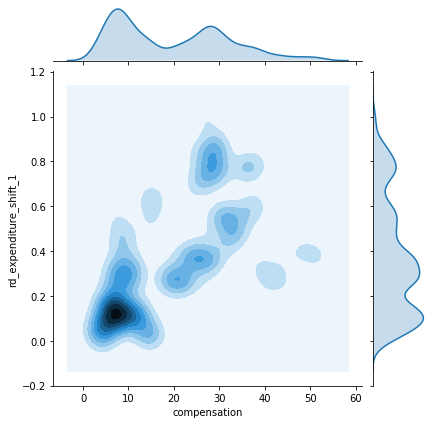

In [10]:
sns.jointplot(data=train_df, x='compensation', y='rd_expenditure_shift_1', kind='kde')

# Train Models

Train models to predict compensation (productivity) using past data.

## LinearRegression

$$
y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i
$$

,features,error,train or test
0,"education_shift_1, population_shift_1, rd_expe...",7.467500,train
2,"education_shift_2, population_shift_2, rd_expe...",7.472414,train
3,"education_shift_2, population_shift_2, rd_expe...",8.094260,test
1,"education_shift_1, population_shift_1, rd_expe...",8.099907,test


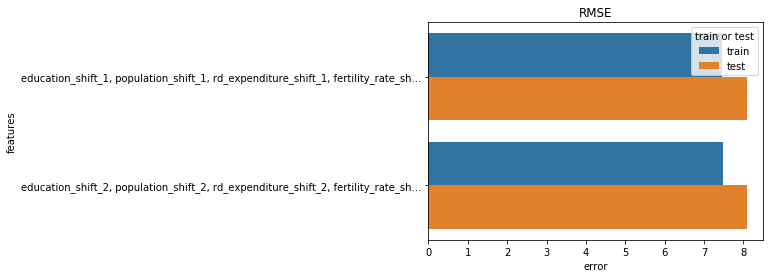

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def fit(features):
    train_temp = train_df[features + ['compensation']].dropna()
    test_temp = test_df[features + ['compensation']].dropna()
    x_train, y_train = train_temp[features], train_temp[['compensation']]
    x_test, y_test = test_temp[features], test_temp[['compensation']]
    
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    train_error = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))
    test_error = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    return train_error, test_error

features = [
    shift_1_features,
    shift_2_features,
]

rows = []
for fs in features:
    train_error, test_error = fit(fs)
    feature_name = ', '.join(fs)
    if len(feature_name) > 80:
        feature_name = feature_name[:80] + '...'
    rows.append({
        'features': feature_name,
        'error': train_error,
        'train or test': 'train'
    })
    rows.append({
        'features': feature_name,
        'error': test_error,
        'train or test': 'test'
    })
    
result = pd.DataFrame(rows).sort_values(by='error')
display(result)

sns.barplot(data=result, x='error', y='features', hue='train or test').set_title('RMSE')
plt.show()

In [12]:
train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## LightGBM

This is a kind of gradient boosting tree.

GitHub: https://github.com/microsoft/LightGBM

In [13]:
import shap
shap.initjs()

In [14]:
from lightgbm import LGBMRegressor

train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

gbm = LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Tune LightGBM using Optuna

Optuna employs a Bayesian optimization algorithm called Tree-structured Parzen Estimator.

Paper: https://arxiv.org/abs/1907.10902
GitHub: https://github.com/optuna/optuna

In [15]:
import lightgbm as lgb
import optuna

def objective(trial):
    param = {
        "objective": "regression",
        "metric": "l2",
        "verbosity": 0,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
    }

    dtrain = lgb.Dataset(x_train, label=y_train)
    gbm = lgb.train(param, dtrain)
    error = np.sqrt(mean_squared_error(y_test, gbm.predict(x_test)))
    return error

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 4.954145832382649
  Params: 
 lambda_l1: 4.8471871138211
 lambda_l2: 0.03652968777657596
 num_leaves: 190
 feature_fraction: 0.9614770171826916
 bagging_fraction: 0.8332047041206913
 bagging_freq: 2
 min_child_samples: 34


In [16]:
dtrain = lgb.Dataset(x_train, label=y_train)
params = trial.params
params['objective'] = 'regression'
tuned_gbm = lgb.train(params, dtrain)
error = np.sqrt(mean_squared_error(y_test, tuned_gbm.predict(x_test)))
error

4.954145832382649

,model,error
0,LinearRegression,8.099907
1,LightGBM,5.140075
2,Tuned LightGBM,4.954146


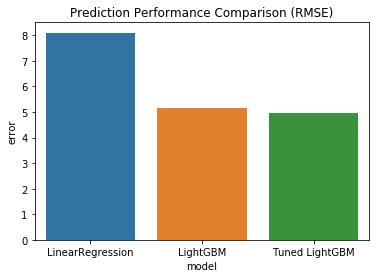

In [17]:
rows = []
rows.append({
    'model': 'LinearRegression',
    'error': np.sqrt(mean_squared_error(y_test, lr.predict(x_test))),
})
rows.append({
    'model': 'LightGBM',
    'error': np.sqrt(mean_squared_error(y_test, gbm.predict(x_test))),
})
rows.append({
    'model': 'Tuned LightGBM',
    'error': np.sqrt(mean_squared_error(y_test, tuned_gbm.predict(x_test))),
})
result = pd.DataFrame(rows).sort_values('error', ascending=False)
display(result)
sns.barplot(data=result, x='model', y='error').set_title('Prediction Performance Comparison (RMSE)')
plt.show()

# Visualize Predictions

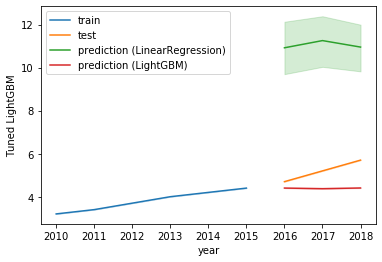

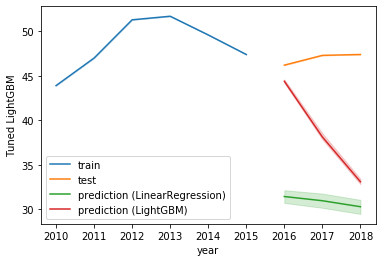

In [18]:
def visualize_prediction(country):
    train_temp = train_df[train_df['GEO'] == country]
    test_temp = test_df[shift_1_features + ['compensation', 'year', 'GEO']].dropna()
    test_temp = test_temp[test_temp['GEO'] == country]
    x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

    test_temp['LinearRegression'] = lr.predict(x_test)
    test_temp['Tuned LightGBM'] = tuned_gbm.predict(x_test)

    sns.lineplot(data=train_temp, x='year', y='compensation', label='train')
    sns.lineplot(data=test_temp, x='year', y='compensation', label='test')
    sns.lineplot(data=test_temp, x='year', y='LinearRegression', label='prediction (LinearRegression)')
    sns.lineplot(data=test_temp, x='year', y='Tuned LightGBM', label='prediction (LightGBM)')
    plt.show()

for country in ['Bulgaria', 'Norway']:
    visualize_prediction(country)

# Visualize Feature Importance

- Coefficients (LinearRegression)
- Feature Importances (Booster)
- Shap (LightBGM)
  - Paper: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions
  - GitHub: https://github.com/slundberg/shap
- InterpretML (ExplainableBoostingRegressor)
  - GitHub: https://github.com/interpretml/interpret

,feature,coef
4,hrst_shift_1,29.491292
2,rd_expenditure_shift_1,10.228855
3,fertility_rate_shift_1,9.608161
5,tax_rate_shift_1,8.124757
1,population_shift_1,5.849285
0,education_shift_1,4.272491


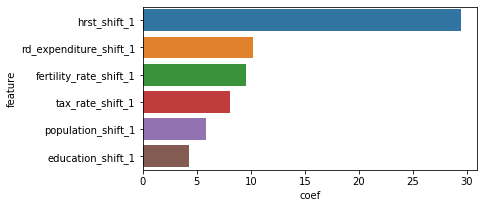

In [19]:
train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

lr = LinearRegression()
lr.fit(x_train, y_train)

result = pd.DataFrame({
    'feature': shift_1_features,
    'coef': lr.coef_[0]
}).sort_values(by=['coef'], ascending=False)
display(result)

plt.figure(figsize=(6, 3))
sns.barplot(data=result, y='feature', x='coef')

,Value,Feature
5,923,population_shift_1
4,605,education_shift_1
3,553,rd_expenditure_shift_1
2,491,fertility_rate_shift_1
1,326,hrst_shift_1
0,102,tax_rate_shift_1


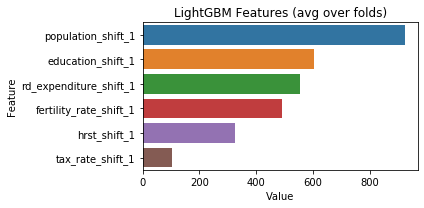

In [20]:
feature_importances = pd.DataFrame(sorted(zip(gbm.feature_importances_, shift_1_features)), columns=['Value','Feature'])
result = feature_importances.sort_values(by="Value", ascending=False)
display(result)

plt.figure(figsize=(6, 3))
sns.barplot(x="Value", y="Feature", data=result)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [21]:
explainer = shap.TreeExplainer(tuned_gbm)
shap_values = explainer.shap_values(x_test)

shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:])

/usr/local/lib/python3.7/site-packages/shap/explainers/tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



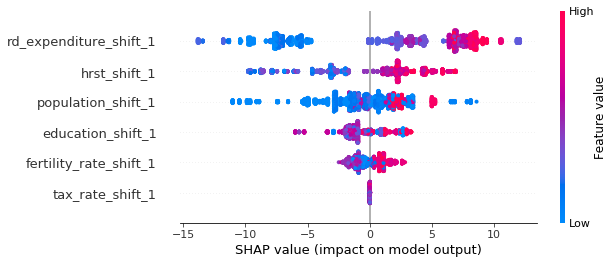

In [22]:
shap.summary_plot(shap_values, x_test)

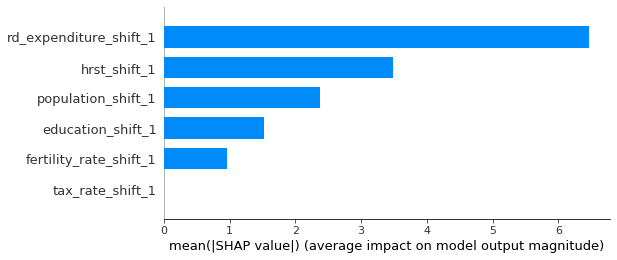

In [23]:
shap.summary_plot(shap_values, x_test, plot_type='bar')

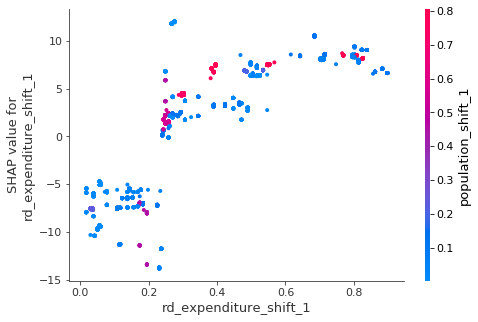

In [24]:
shap.dependence_plot('rd_expenditure_shift_1', shap_values, x_test)

## ExplainableBoostingRegressor (from InterpretML)

EBM is a generalized additive model formalized as follows.

$$
g(E[y]) = \beta_0 + \sum f_j(x_j) + \sum f_{ij}(x_i,x_j)
$$

EBM learns the best feature function $f_j$ for each feature to show how each feature contributes to the model's prediction for the problem. EBM can also automatically detect and include pairwise interaction terms.

Paper: https://arxiv.org/pdf/1909.09223.pdf

### Global Explanation

In [25]:
from sklearn.model_selection import train_test_split
import interpret
from interpret.glassbox import ExplainableBoostingRegressor

train_temp = train_df[shift_1_features + ['compensation']].dropna()
test_temp = test_df[shift_1_features + ['compensation']].dropna()
x_train, y_train = train_temp[shift_1_features], train_temp[['compensation']]
x_test, y_test = test_temp[shift_1_features], test_temp[['compensation']]

ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(x_train, y_train)

ebm_global = ebm.explain_global(name='EBM')
interpret.show(ebm_global)

<!-- http://127.0.0.1:7082/5088386000/ -->

### Local Explanation

In [26]:
ebm_local = ebm.explain_local(x_test[:5], y_test[:5], name='EBM')
interpret.show(ebm_local)

<!-- http://127.0.0.1:7082/5087073936/ -->

In [27]:
from interpret.glassbox import LinearRegression
from interpret.perf import RegressionPerf

ebm_perf = RegressionPerf(ebm.predict).explain_perf(x_test, y_test, name='Linear Regression')
interpret.show(ebm_perf)

<!-- http://127.0.0.1:7082/5080972496/ -->